Set up the program and load the economic data.

In [6]:
import pandas as pd
import warnings
import sys
import os
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.simplefilter('ignore')
sys.tracebacklimit = 0
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Load dataset from provided expanded dataset file
data = pd.read_csv("expanded_economic_data.csv")

Get the data cleaned up and ready to use

In [9]:
# Rename DATE column to Date to match code expectations
data.rename(columns={'DATE': 'Date'}, inplace=True)

# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature Engineering - Lag features and rolling averages
data['Unemployment_Lag1'] = data['Unemployment_Rate'].shift(1)
data['GDP_Lag1'] = data['GDP_Growth'].shift(1)
data['Inflation_RollingMean'] = data['Inflation'].rolling(window=3).mean()
data['Retail_Sales_RollingMean'] = data['Retail_Sales'].rolling(window=3).mean()

data.dropna(inplace=True)  # Drop NaN values from shifting


Explore the data

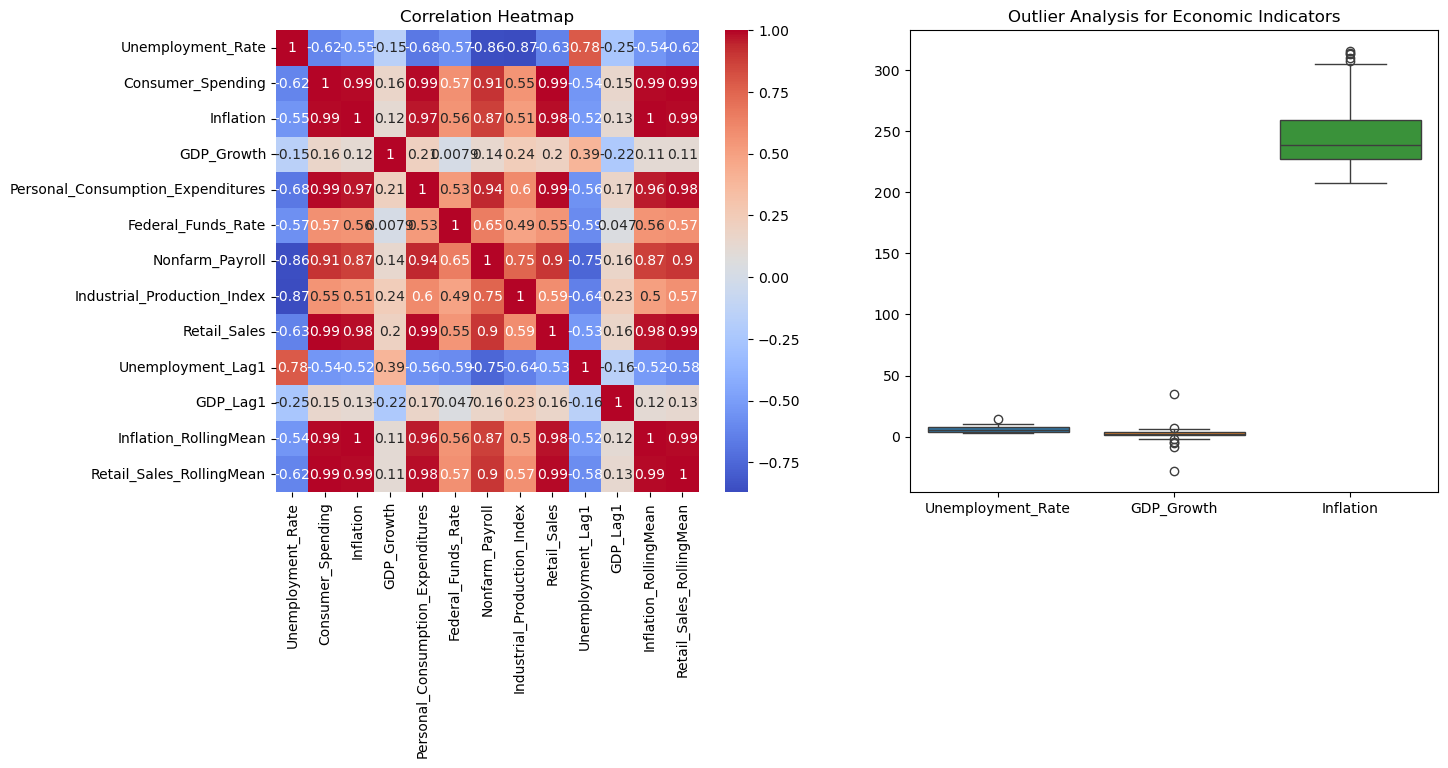

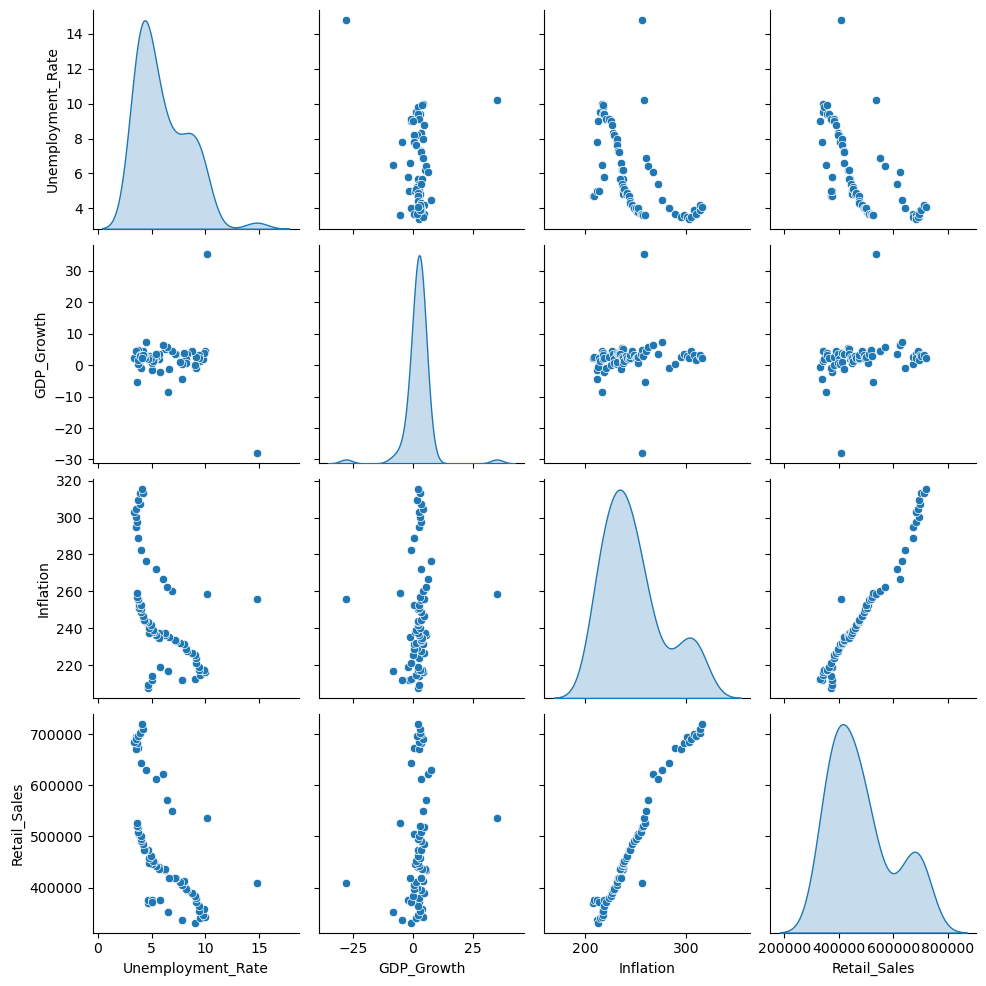

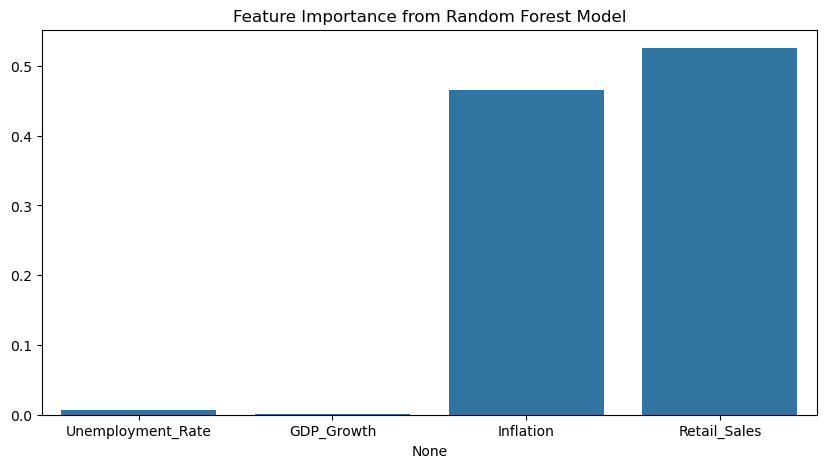

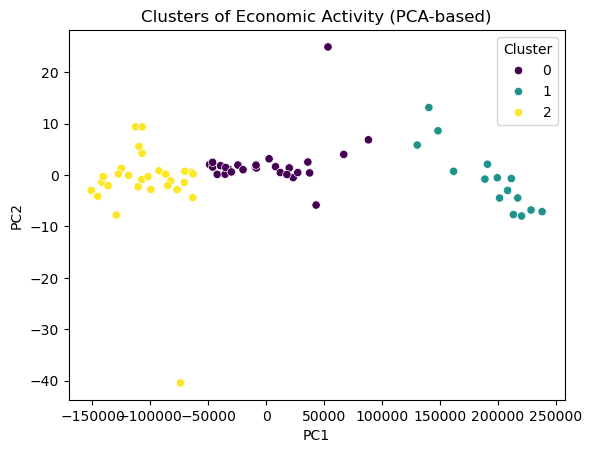

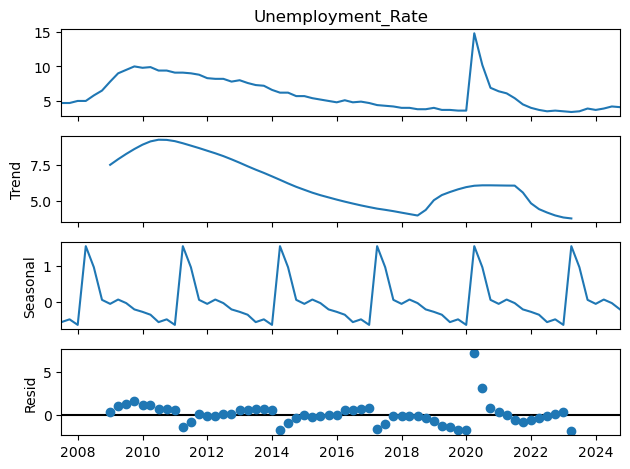

In [12]:
# Exploratory Data Analysis (EDA) - Heatmap and Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title("Correlation Heatmap")

sns.boxplot(data=data[['Unemployment_Rate', 'GDP_Growth', 'Inflation']], ax=axes[1])
axes[1].set_title("Outlier Analysis for Economic Indicators")
plt.show()

# Pairplot for detailed EDA
sns.pairplot(data[['Unemployment_Rate', 'GDP_Growth', 'Inflation', 'Retail_Sales']], diag_kind='kde')
plt.show()

# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data[['Unemployment_Rate', 'GDP_Growth', 'Inflation', 'Retail_Sales']])
data['PC1'], data['PC2'] = principal_components[:,0], principal_components[:,1]

# Feature Importance Visualization
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(data[['Unemployment_Rate', 'GDP_Growth', 'Inflation', 'Retail_Sales']], data['Consumer_Spending'])

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=data[['Unemployment_Rate', 'GDP_Growth', 'Inflation', 'Retail_Sales']].columns, y=rf_model.feature_importances_, ax=ax)
ax.set_title("Feature Importance from Random Forest Model")
plt.show()

# Clustering Analysis
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['PC1', 'PC2']])

# Clustering Visualization
sns.scatterplot(x=data['PC1'], y=data['PC2'], hue=data['Cluster'], palette='viridis')
plt.title("Clusters of Economic Activity (PCA-based)")
plt.show()

# Time Series Decomposition
decomposition = seasonal_decompose(data['Unemployment_Rate'], model='additive', period=12)
decomposition.plot()
plt.show()


Analyise the data

Linear Regression - Mean Squared Error: 29310.101484298397
Linear Regression - R-squared Score: 0.9960216997183324
Ridge Regression - Mean Squared Error: 29327.71141576046
Lasso Regression - Mean Squared Error: 29309.383807569346
Bagging Regressor - Mean Squared Error: 32140.60762083888
Random Forest - Mean Squared Error: 15435.853094856997
Cross-Validation MSE Scores: [ 1376563.45463601   217342.60870678   181295.81202634   666505.11115871
 10464017.84575796]
Mean MSE: 2581144.966457161
Boosting (AdaBoost) - Mean Squared Error: 33447.501746168324


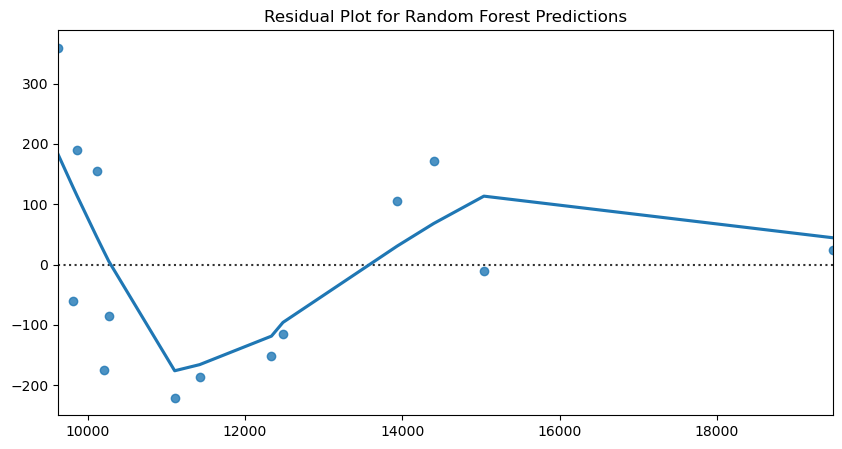

In [15]:
# Regression Analysis
X = data[['Unemployment_Rate', 'Unemployment_Lag1', 'GDP_Lag1', 'Inflation_RollingMean', 'Retail_Sales_RollingMean']]
y = data[['Consumer_Spending']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)

print("Linear Regression - Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Linear Regression - R-squared Score:", r2_score(y_test, y_pred))

# Regularization Techniques - Ridge and Lasso Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
print("Ridge Regression - Mean Squared Error:", mean_squared_error(y_test, ridge_pred))

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)
print("Lasso Regression - Mean Squared Error:", mean_squared_error(y_test, lasso_pred))

# Ensemble Learning - Bagging, Random Forest, and Boosting
bagging_model = BaggingRegressor(estimator=LinearRegression(), n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train.values.ravel())
bagging_pred = bagging_model.predict(X_test)
print("Bagging Regressor - Mean Squared Error:", mean_squared_error(y_test, bagging_pred))

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())
rf_pred = rf_model.predict(X_test)
print("Random Forest - Mean Squared Error:", mean_squared_error(y_test, rf_pred))

cv_scores = cross_val_score(RandomForestRegressor(), X, y.values.ravel(), cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation MSE Scores:", -cv_scores)
print("Mean MSE:", -cv_scores.mean())

boosting_model = AdaBoostRegressor(n_estimators=50, random_state=42)
boosting_model.fit(X_train, y_train.values.ravel())
boosting_pred = boosting_model.predict(X_test)
print("Boosting (AdaBoost) - Mean Squared Error:", mean_squared_error(y_test, boosting_pred))

# Regression Residuals Plot
plt.figure(figsize=(10,5))
sns.residplot(x=y_pred.flatten(), y=y_test.values.flatten(), lowess=True)
plt.title("Residual Plot for Random Forest Predictions")
plt.show()


Make sure all is well

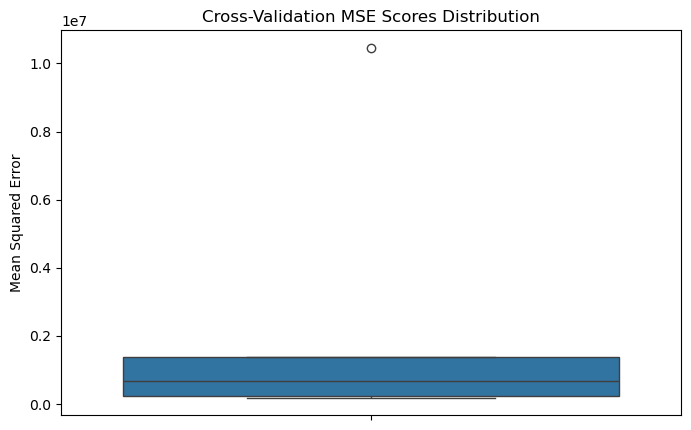

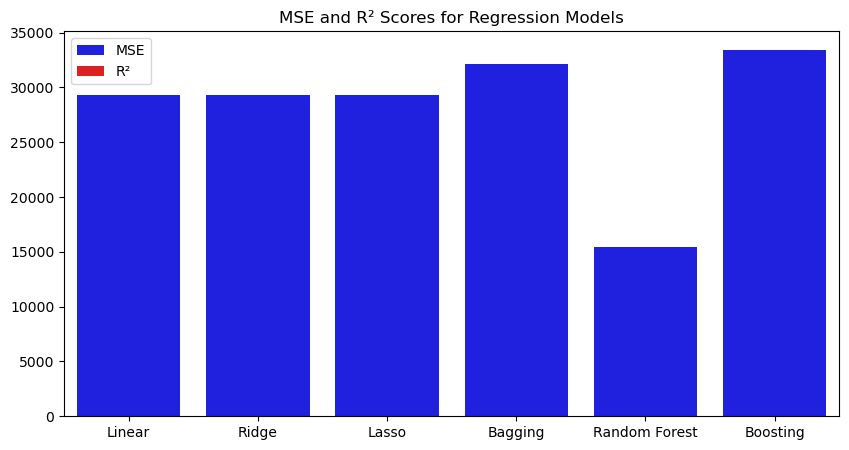

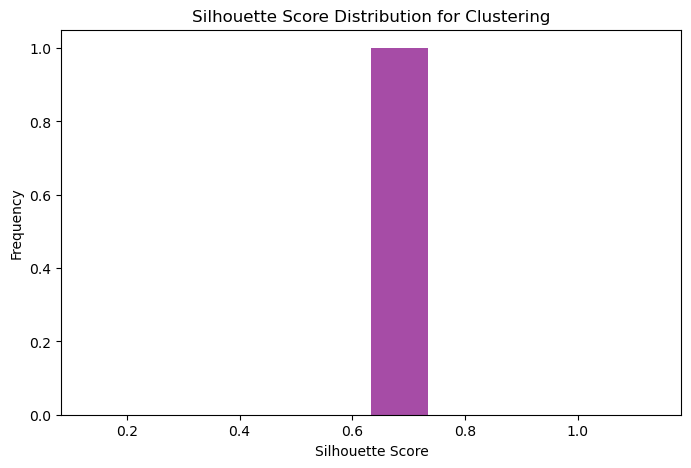

In [18]:
# Cross-Validation MSE Visualization
plt.figure(figsize=(8,5))
sns.boxplot(data=-cv_scores)
plt.title("Cross-Validation MSE Scores Distribution")
plt.ylabel("Mean Squared Error")
plt.savefig("cross_validation_score_final.png")
plt.show()

# MSE & R² Scores Visualization
metrics = ["Linear", "Ridge", "Lasso", "Bagging", "Random Forest", "Boosting"]
mse_values = [
    mean_squared_error(y_test, y_pred),
    mean_squared_error(y_test, ridge_pred),
    mean_squared_error(y_test, lasso_pred),
    mean_squared_error(y_test, bagging_pred),
    mean_squared_error(y_test, rf_pred),
    mean_squared_error(y_test, boosting_pred)
]
r2_values = [
    r2_score(y_test, y_pred),
    r2_score(y_test, ridge_pred),
    r2_score(y_test, lasso_pred),
    r2_score(y_test, bagging_pred),
    r2_score(y_test, rf_pred),
    r2_score(y_test, boosting_pred)
]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=metrics, y=mse_values, color='blue', label='MSE')
sns.barplot(x=metrics, y=r2_values, color='red', label='R²')
ax.set_title("MSE and R² Scores for Regression Models")
plt.legend()
plt.savefig("mse_r2_score_final.png")
plt.show()

# Silhouette Score Visualization
silhouette_avg = silhouette_score(data[['PC1', 'PC2']], data['Cluster'])
plt.figure(figsize=(8,5))
plt.hist(silhouette_avg, bins=10, color='purple', alpha=0.7)
plt.title("Silhouette Score Distribution for Clustering")
plt.xlabel("Silhouette Score")
plt.ylabel("Frequency")
plt.show()